* * *
<pre> NYU Paris            <i> Machine Learning - Summer 2023 </i></pre>
* * *


<h1 align="center"> Lab: the multilayer perceptron </h1>

<pre align="left"> June 07th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goal:
- Implement your Multilayer perceptron model

## Installing and importing Pytorch

In [1]:
%pip install torch torchvision
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor


# Versions of torch and torchvision have to be compatible.
# check here: https://github.com/pytorch/pytorch/wiki/PyTorch-Versions

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torchvision

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cpu
0.22.1+cpu


### Loading and preparing the MNIST dataset

In [ ]:
# Define training and testing data using the functions in the cell above. 
# 定义好的函数，自动下载MINIST数据集，并将其转换为Tensor格式。
# MNIST数据集是手写数字识别数据集，包含60000个训练样本和10000个测试样本。
# 使用ToTensor()转换数据集中的图像数据为Tensor (转化为张量) 格式，以便于PyTorch处理。
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Question 1

### Visualize some elements of the dataset:

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


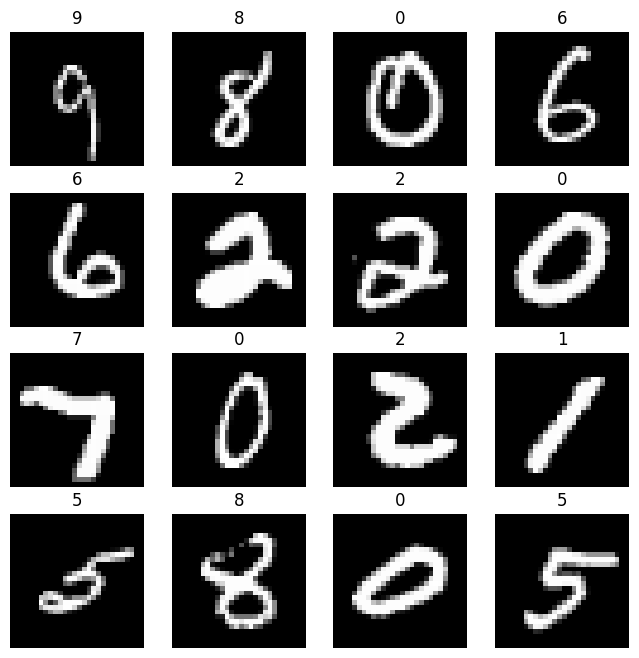

In [5]:
import matplotlib.pyplot as plt
# Visualize some images of the MNIST dataset
# Size of training data
print(train_data.data.shape)

# Size of testing data
print(test_data.data.shape)

# Create a mapping from label indices to label names
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
# 生成图片
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4

# Randomly select images from the training dataset
for i in range(1, cols * rows + 1):
    # 从 train_data 中随机选择一个样本
    # Note: train_data is a Dataset object, so we can access its elements using indexing.
    # The dataset returns a tuple (image, label) for each sample.
    # We use torch.randint to generate a random index.
    # size = (1,) 是为了生成一个数 and .item() 把它从张量转换为 Python 整数   
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    # 通过随机生成的 idx 获取图像和标签
    img, label = train_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# target 是一个属性，也就是包含了所有标签的一个tensor
train_data.targets

# [0] 取出这个 tensor 的第一个元素，但还是一个tensor
train_data.targets[0]

# .item() 将这个 tensor 转换为 Python 的整数
train_data.targets[0].item()

5

## Question 2

### Define a dataloader to construct a batch-wise iterator from your train/test data


In [11]:
# data 用于批量加载数据，目的是把 dataset 分成小批量（batch），并在训练时自动迭代，这些批次，以便于训练和测试模型。
from torch.utils.data import DataLoader

BATCH_SIZE = 4
# suffle=True 表示每次迭代时打乱数据的顺序
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# testloader 用于测试数据集的加载，通常不需要打乱顺序，因为测试数据集的顺序不影响模型评估。
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## Question 3

### Design your own Neural Network

In [12]:
# nn 是神经网络模块
# F 是 PyTorch 的函数式接口，提供了许多常用的激活函数和损失函数等
import torch.nn as nn
import torch.nn.functional as F

# 先定义input，hidden 和 output 的维度
# number of features (len of X cols)，input 的维度
input_dim = 28 * 28 # 代表有多少像素

# number of neurons in the hidden layer (一个隐藏层里有多少个神经元，也就是这个隐藏层的维度)
hidden_dim = 256
 
# number of classes (unique of y) output 的维度
output_dim = 10

# 定义一个多层感知机（MLP）模型
# 输入层 → 线性层1（Linear）→ 激活函数（ReLU）→ 线性层2 → 输出层！！！
class MLP(nn.Module):
    def __init__(self):
        # super() 函数在 Python 中的作用是：调用父类的方法。在 PyTorch 中，使用 super() 是定义神经网络类时的标准做法，尤其是在继承 nn.Module 的类中
        super(MLP, self).__init__()

        # 第一个全链接层，把 28*28 的 input 映射到 256 维的隐藏层
        self.linear1 = nn.Linear(input_dim, hidden_dim) # linear() 函数实现了一个线性变换，y = Wx + b
        # 第二个全链接层，把 256 维的隐藏层映射到 10 维的输出层
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    # forward 方法定义了向前传播过程
    def forward(self, x):
        # x 是输入数据，形状为 (batch_size, 1, 28, 28)
        # 首先将输入数据展平为一维向量，形状变为 (batch_size, 28*28)
        x = x.view(-1, input_dim) # 通过 view() 展平为对应 size，-1 表示自动计算 batch size

        # 通过第一个线性层进行线性变换，需要调用 relu 这个 activation function
        h_relu = F.relu(self.linear1(x)) # 放入 ReLU 函数的是通过线性变换的 input g(W1x + b1)
        # 通过第二个线性层进行线性变换，得到输出
        y_pred = self.linear2(h_relu)
        
        return y_pred

## Question 4

### Train your neural network on the trainloader

In [20]:
# 引入一些基本的 loss functions 和优化器
from torch.nn.functional import nll_loss, cross_entropy
import torch.optim as optim

# 定义一个 MLP object, parameters() 是模型中所有可训练参数的集合，W 和 b
mlp = MLP()
print(mlp.parameters)

# Optimizer
epochs = 2 # 训练轮数是 2（即遍历整个训练集两次）

learning_rate = 1e-6 # learning rate 是优化器的超参数，控制模型参数更新的步长，优化中最重要的步骤

# Adam 是一种自适应学习率优化算法，参与优化的是所有参数，按照学习率更新参数
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate) 

# Choice of the loss （MLP中采用 cross_entropy loss）
criterion = cross_entropy # nll_loss

losses = []
for t in range(epochs):
    # enumerate(trainloader) 返回一个 iter，返回每个批次的索引和数据
    for i, data in enumerate(trainloader): # 这里的索引 i 代表从第一个 batch， data 代表 (inputs, lables）
        inputs, labels = data
        
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad() # 清空上一次的迭代梯度，避免梯度累加（因为这里是梯度下降的方法不要累加）
        
        # Evaluate the loss
        outputs = mlp(inputs) # 计算出预测值
       
        # loss = nll_loss(outputs, labels)
        loss = cross_entropy(outputs, labels) # 计算预测和实际之间的 cross entropy loss
        
        # backward propagation!!!! 根据当前loss自动计算 gredient
        loss.backward() # 反向传播，计算梯度
        
        # One optimization step!!! optimizer.step() 更具上面 backward propagation计算的梯度来更新参数
        optimizer.step()

        # 将 loss 添加到 losses 列表中
        losses.append(loss.item())
        
        # 每 2000 次迭代打印一次当前的 epoch(轮次）、batch（批次） 和 当前loss
        if not i % 2000:
            print(t, i, loss.item())


<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
0 0 2.3706157207489014
0 2000 2.236297607421875
0 4000 2.1324565410614014
0 6000 2.013789176940918
0 8000 2.0789449214935303
0 10000 1.8613252639770508
0 12000 1.9076274633407593
0 14000 1.943622350692749
1 0 1.9023704528808594
1 2000 1.8789924383163452
1 4000 1.8898820877075195
1 6000 1.8957710266113281
1 8000 1.4519314765930176
1 10000 1.8312351703643799
1 12000 1.8045127391815186
1 14000 1.775963544845581


## Question 5

### Inspect the optimization procedure through the loss (plot the loss), what do you observe?

'\n震荡存在但合理, 你会看到蓝线有许多“锯齿状”的震荡，这是正常现象，原因是：\n\n训练是基于 每个 mini-batch 更新一次梯度，每个 batch 的数据不同 → 损失值也会有差异；\n\n学习率可能比较小,比如你前面用了 1e-6,导致震荡幅度不是特别剧烈\n\n如果震荡太大，可能需要：增大 batch size, 减小学习率, 添加平滑处理(如 moving average)\n'

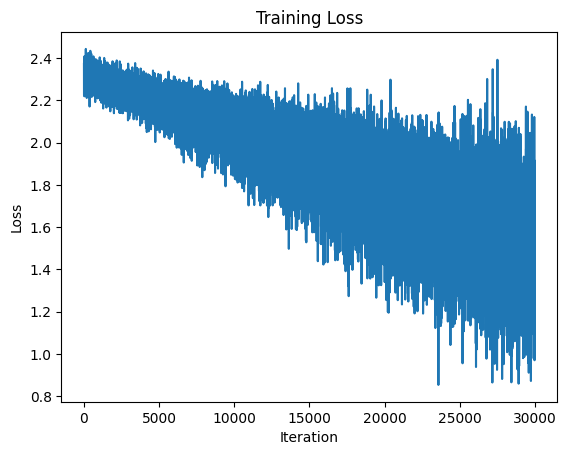

In [18]:
# 两个轮次的训练，发现每两千个批次的 loss 都在下降，说明模型在学习。
# cross entropy loss 从 2.3 降到 1.36
# 绘制损失曲线
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

"""
震荡存在但合理, 你会看到蓝线有许多“锯齿状”的震荡，这是正常现象，原因是：

训练是基于 每个 mini-batch 更新一次梯度，每个 batch 的数据不同 → 损失值也会有差异；

学习率可能比较小,比如你前面用了 1e-6,导致震荡幅度不是特别剧烈

如果震荡太大，可能需要：增大 batch size, 减小学习率, 添加平滑处理(如 moving average)
"""

## Question 6

### Evaluate the quality of your classifier on the test set

In [ ]:
# 取出测试集样本总数
size_test = test_data.data.shape[0]

correct = 0 # 用于记录预测正确的样本数

for data in testloader:
    inputs, labels = data
    outputs = mlp(inputs)
    loss = cross_entropy(outputs, labels)
    # 获取每个样本的预测标签
    # torch.max(outputs, 1) 返回一个元组，第一个元素是最大值，第二个元素是最大值的索引
    _, predicted = torch.max(outputs, 1) # 取每个样本中最大值所在的位置（即最可能的类别), 
    # _,是一个占位符，表示我们不关心最大值本身，只关心索引

    correct += (predicted == labels).sum()


final_accuracy =  correct/size_test

print(final_accuracy)

tensor(0.7936)


## Question 7 (Bonus)

### Repeat this training with different loss (nll/cross_entropy...) and different number of epochs. What do you observe?

In [ ]:
# change bach size 
# change learning rate
# change loss function
# change epochs
# change hidden layer size
# change optimizer